# Предсказание уровня удовлетворенности и увольнение сотрудника.

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

**Перед нами стоит две задачи(Цель моделей):** 

    1) построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
    2) построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Ход исследования:**

    - Загрузка данных
    - Предобработка данных
    - Исследовательский анализ данных
    - Подготовка данных
    - Обучение моделей
    - Выводы к первой задаче
    - Дополнительный исследовательский анализ
    - Добавление входных признаков к данным
    - Подготовка новых данных
    - Обучение моделей

In [1]:
!pip install phik -q

In [2]:
!pip install scikit-learn==1.1.3 -q

In [3]:
!pip install shap -q

In [4]:
!pip install --upgrade shap matplotlib==3.5.2 numpy==1.25.0 -q

In [5]:
!pip install featuretools -q

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
import featuretools as ft

from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Используем RandomizedSearchCV, чтобы затратить меньше ресурсов и быстрее выбрать модель.
from sklearn.model_selection import (
    RandomizedSearchCV, 
    StratifiedKFold, 
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from lightgbm import LGBMRegressor, LGBMClassifier

In [7]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [8]:
job_satisfaction_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')

In [9]:
job_satisfaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [10]:
job_satisfaction_train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [11]:
job_satisfaction_train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [12]:
quit_train = pd.read_csv('/datasets/train_quit.csv')

In [13]:
quit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [14]:
quit_train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [15]:
quit_train.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [16]:
features_test = pd.read_csv('/datasets/test_features.csv')

In [17]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [18]:
features_test.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [19]:
features_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [20]:
job_satisfaction_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [21]:
job_satisfaction_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [22]:
job_satisfaction_target.head(5)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [23]:
quit_target = pd.read_csv('/datasets/test_target_quit.csv')

In [24]:
quit_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [25]:
quit_target.head(5)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Вывод:**

    - Были выгружены данные из пяти разных файлов в четыре переменные. Все данные соответствуют описанию.
    - В таблице job_satisfaction_train 4000 записи с колонками, совпадающими с описанием.
    - В таблице quit_train 4000 записи с колонками, совпадающими с описанием.
    - В таблице features_test 2000 записей с колонками, совпадающими с описанием.
    - В таблице job_satisfaction_target 2000 записей с колонками id и job_satisfaction_rate.
    - В таблице quit_target 2000 записей с колонками id и quit.

## Предобработка данных

**job_satisfaction_train**

In [26]:
job_satisfaction_train.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [27]:
job_satisfaction_train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [28]:
job_satisfaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [29]:
job_satisfaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [30]:
job_satisfaction_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [31]:
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [32]:
job_satisfaction_train.loc[job_satisfaction_train['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [33]:
job_satisfaction_train.loc[job_satisfaction_train['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [34]:
job_satisfaction_train[['dept', 'level', 'workload']] = imputer_pipe.fit_transform(job_satisfaction_train[['dept', 'level', 'workload']])

In [35]:
job_satisfaction_train.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [36]:
job_satisfaction_train.duplicated().sum()

0

In [37]:
job_satisfaction_train.nunique()

id                       4000
dept                        5
level                       3
workload                    3
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     68
job_satisfaction_rate      98
dtype: int64

In [38]:
job_satisfaction_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing'],
      dtype=object)

In [39]:
job_satisfaction_train['level'].unique()

array(['junior', 'middle', 'sinior'], dtype=object)

In [40]:
job_satisfaction_train['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [41]:
job_satisfaction_train['employment_years'].unique()

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

In [42]:
job_satisfaction_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [43]:
job_satisfaction_train['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [44]:
job_satisfaction_train['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4])

In [45]:
job_satisfaction_train['level'] = job_satisfaction_train['level'].replace(['sinior'], 'senior')

In [46]:
job_satisfaction_train['level'].unique()

array(['junior', 'middle', 'senior'], dtype=object)

**features_test**

In [47]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [48]:
features_test.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [49]:
features_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [50]:
features_test.loc[features_test['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [51]:
features_test.loc[features_test['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [52]:
features_test[['dept', 'level', 'workload']] = imputer_pipe.transform(features_test[['dept', 'level', 'workload']])

In [53]:
features_test.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [54]:
features_test.duplicated().sum()

0

In [55]:
features_test.nunique()

id                       2000
dept                        6
level                       3
workload                    4
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     66
dtype: int64

In [56]:
for column in ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']:
    print(column+':', features_test[column].unique())

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' ' ']
level: ['junior' 'middle' 'sinior']
workload: ['medium' 'low' 'high' ' ']
employment_years: [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [5 4 3 1 2]


In [57]:
features_test.loc[features_test['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [58]:
features_test['dept'] = features_test['dept'].replace(r'^\s*$', np.nan, regex=True)

In [59]:
features_test.loc[features_test['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [60]:
features_test[['dept', 'level', 'workload']] = imputer_pipe.transform(features_test[['dept', 'level', 'workload']])

In [61]:
features_test.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [62]:
for column in ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']:
    print(column+':', features_test[column].unique())

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology']
level: ['junior' 'middle' 'sinior']
workload: ['medium' 'low' 'high' ' ']
employment_years: [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [5 4 3 1 2]


In [63]:
features_test['level'] = features_test['level'].replace(['sinior'], 'senior')

In [64]:
features_test.loc[features_test['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [65]:
features_test['workload'] = features_test['workload'].replace(r'^\s*$', np.nan, regex=True)

In [66]:
features_test[['dept', 'level', 'workload']] = imputer_pipe.transform(features_test[['dept', 'level', 'workload']])

In [67]:
# копирование, потому что поздно увидел, что тут одни и те же поля имеют ошибки
for column in ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']:
    print(column+':', features_test[column].unique())

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology']
level: ['junior' 'middle' 'senior']
workload: ['medium' 'low' 'high']
employment_years: [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [5 4 3 1 2]


**job_satisfaction_target**

In [68]:
job_satisfaction_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [69]:
job_satisfaction_target.head(5)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [70]:
job_satisfaction_target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

In [71]:
job_satisfaction_target.duplicated().sum()

0

In [72]:
### Решил проверить таргет данные тоже, на всякий случай. 
### Так как пока был перерыв между блоками и попробовал кое что самостоятельно,
### выгружая данные самостоятельно, все равно сделал косяков. Так что подстраховался)

**Вывод:**

    - Заполнены наиболелее релевантными значениями NaN значения и пустые строки из таблиц с тренировочными и тестовыми входными признаками.
    - Переименованы значения с 'sinior' на 'senior'.
    - Дубликатов не найдено.

## Исследовательский анализ

In [73]:
job_satisfaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [74]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [75]:
test_analyze = features_test.merge(job_satisfaction_target, right_index=True, left_index=True)

In [76]:
test_analyze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_x                   2000 non-null   int64  
 1   dept                   2000 non-null   object 
 2   level                  2000 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   id_y                   2000 non-null   int64  
 10  job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 172.0+ KB


In [77]:
test_analyze.head(10)

,id_x,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,id_y,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,130604,0.74
1,686555,hr,junior,medium,1,no,no,4,30000,825977,0.75
2,467458,sales,middle,low,5,no,no,4,19200,418490,0.60
3,418655,sales,middle,low,6,no,no,4,19200,555320,0.72
4,789145,hr,middle,medium,5,no,no,5,40800,826430,0.08
5,429973,purchasing,middle,medium,6,no,no,3,42000,817219,0.76
6,850699,technology,junior,medium,3,no,no,3,26400,269033,0.64
7,500791,sales,middle,high,9,no,no,4,49200,962356,0.38
8,767867,marketing,middle,high,3,no,yes,4,62400,649052,0.14
9,937235,sales,junior,medium,1,no,yes,3,26400,532834,0.59


**Будем считать, что удовлетворение сотрудников ниже медианы соответствуют скорому увольнению:**

In [78]:
job_satisfaction_train['job_satisfaction_rate'].median()

0.56

In [79]:
job_ready_to_quit = job_satisfaction_train.loc[job_satisfaction_train['job_satisfaction_rate'] < job_satisfaction_train['job_satisfaction_rate'].median()]

In [80]:
def pivot_pie(title, table, index, values, funcs):
    pivot = table.pivot_table(index=index, values=values, aggfunc=funcs)
    
    if funcs[0] == 'count':
        total = pivot[funcs[0]].sum()
        pivot['Количество'] = pivot[funcs[0]] / total
        pivot['Количество'].plot(kind='pie', autopct='%.1f%%', figsize=(10, 10), startangle=90)
    else:
        pivot.columns = funcs
        for f in funcs:
            pivot[f].plot(kind='pie', autopct='%.1f%%', figsize=(10, 7), startangle=90)
    plt.title(title)
    plt.legend()
    plt.show()

In [81]:
def pivot_bar(title, ylabel, xlabel, table, index, values, funcs):
    pivot = table.pivot_table(index=index, values=values, aggfunc=funcs).sort_values(by=index)
    
    if funcs[0] == 'count':
        pivot.plot(kind='bar', y='count', figsize=(15, 7), grid=True)
    else:
        pivot.columns = funcs
        for f in funcs:
            pivot.plot(kind='bar', y=f, figsize=(20, 7), grid=True)
    plt.title(title)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

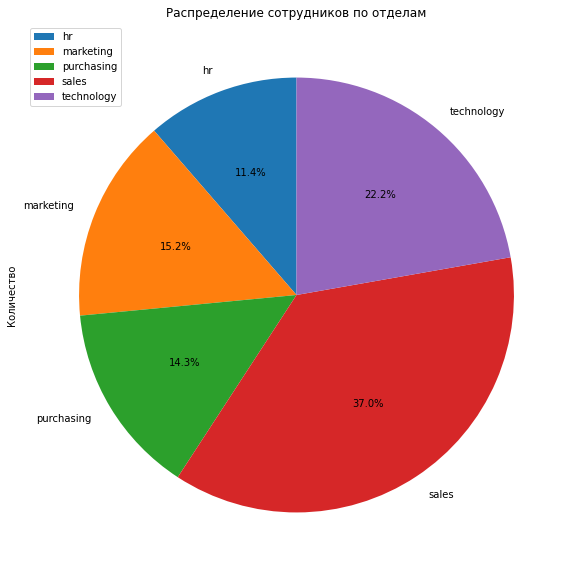

In [82]:
pivot_pie('Распределение сотрудников по отделам', job_ready_to_quit, 'dept', 'id', ['count'])

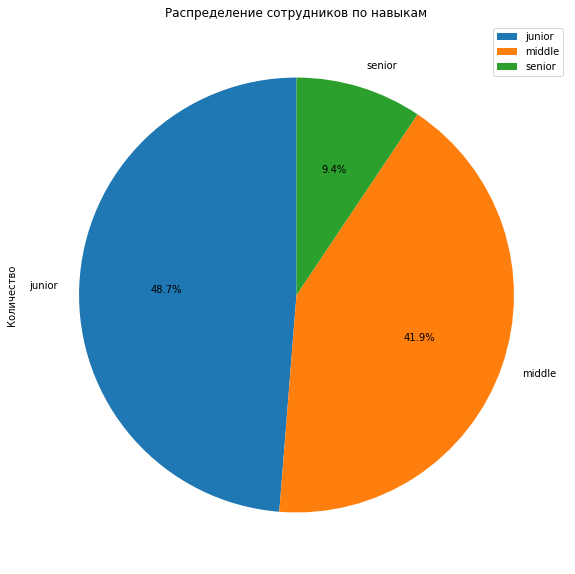

In [83]:
pivot_pie('Распределение сотрудников по навыкам', job_ready_to_quit, 'level', 'id', ['count'])

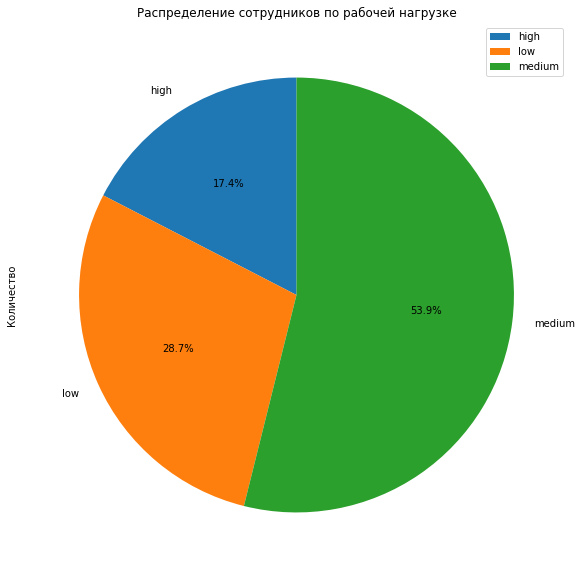

In [84]:
pivot_pie('Распределение сотрудников по рабочей нагрузке', job_ready_to_quit, 'workload', 'id', ['count'])

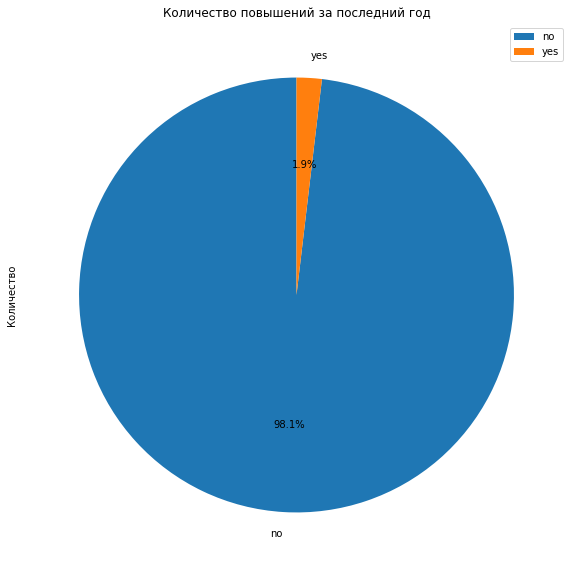

In [85]:
pivot_pie('Количество повышений за последний год', job_ready_to_quit, 'last_year_promo', 'id', ['count'])

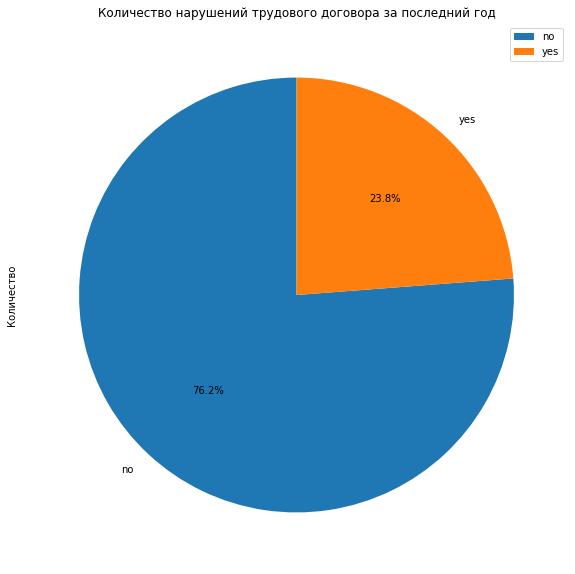

In [86]:
pivot_pie('Количество нарушений трудового договора за последний год', job_ready_to_quit, 'last_year_violations', 'id', ['count'])

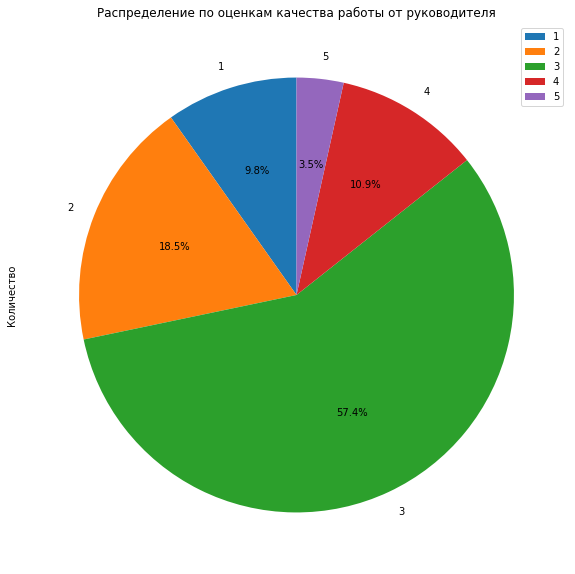

In [87]:
pivot_pie('Распределение по оценкам качества работы от руководителя', job_ready_to_quit, 'supervisor_evaluation', 'id', ['count'])

_Распределение категориальных признаков вполне предсказуемое - больше всего сотрудников в отделе продаж, количества специалистов уровня junior(senior меньше всего), нагрузка умеренная, мало повышений и нарушений трудового договора соответственно._

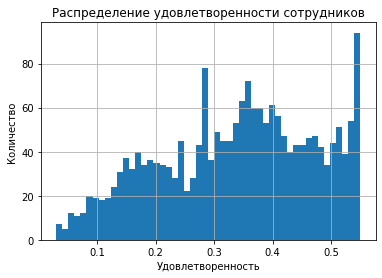

In [88]:
plt.hist(job_ready_to_quit['job_satisfaction_rate'], bins=50)
plt.grid(True)
plt.title('Распределение удовлетворенности сотрудников')
plt.xlabel('Удовлетворенность')
plt.ylabel('Количество')

plt.show()

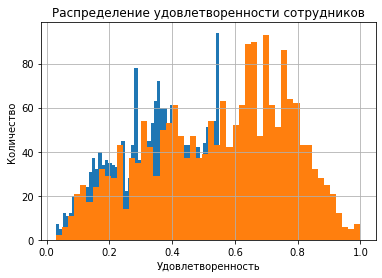

In [89]:
plt.hist(job_ready_to_quit['job_satisfaction_rate'], bins=50)
plt.grid(True)
plt.title('Распределение удовлетворенности сотрудников')
plt.xlabel('Удовлетворенность')
plt.ylabel('Количество')

plt.hist(test_analyze['job_satisfaction_rate'], bins=50)
plt.grid(True)
plt.title('Распределение удовлетворенности сотрудников')
plt.xlabel('Удовлетворенность')
plt.ylabel('Количество')

plt.show()

_Удовлетворенность сотрудников преобладает на хорошем уровне._

In [90]:
job_satisfaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Text(0, 0.5, 'Количество')

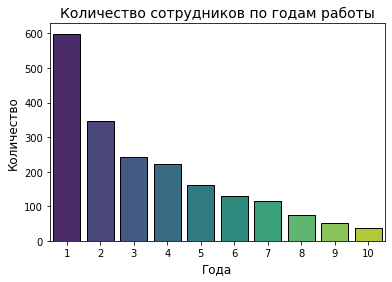

In [91]:
ax = sns.countplot(
    x=job_ready_to_quit['employment_years'],
    data=job_ready_to_quit['employment_years'],
    palette='viridis',
    edgecolor='black'
)

# Добавление подписей
plt.title('Количество сотрудников по годам работы', fontsize=14)
plt.xlabel('Года', fontsize=12)
plt.ylabel('Количество', fontsize=12)

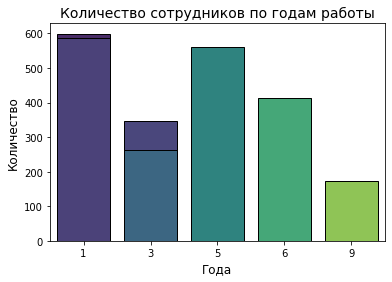

In [92]:
ax = sns.countplot(
    x=job_ready_to_quit['employment_years'],
    data=job_ready_to_quit['employment_years'],
    palette='viridis',
    edgecolor='black'
)

ax2 = sns.countplot(
    x=test_analyze['employment_years'],
    data=test_analyze['employment_years'],
    palette='viridis',
    edgecolor='black'
)

# Добавление подписей
plt.title('Количество сотрудников по годам работы', fontsize=14)
plt.xlabel('Года', fontsize=12)
plt.ylabel('Количество', fontsize=12)

plt.show()

In [93]:
#plt.hist(job_ready_to_quit['employment_years'], bins=20)
#plt.grid(True)
#plt.title('Распределение длительности работы в компании в годах')
#plt.xlabel('Длительность')
#plt.ylabel('Количество')
#plt.show()

#plt.boxplot(job_ready_to_quit['employment_years'])
#plt.grid(True)

_Новых сотрудников сильно больше, чем "старичков". Это свидетельствует о большой "текучке" в компании - нехороший знак._

Text(0, 0.5, 'Количество')

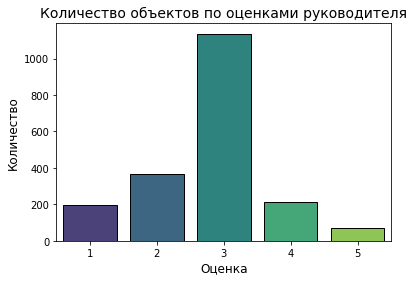

In [94]:
ax = sns.countplot(
    x=job_ready_to_quit['supervisor_evaluation'],
    data=job_ready_to_quit['supervisor_evaluation'],
    palette='viridis',
    edgecolor='black'
)

# Добавление подписей
plt.title('Количество объектов по оценками руководителя', fontsize=14)
plt.xlabel('Оценка', fontsize=12)
plt.ylabel('Количество', fontsize=12)

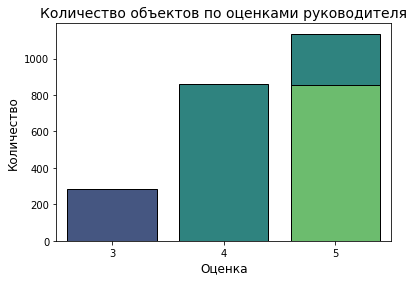

In [95]:
ax = sns.countplot(
    x=job_ready_to_quit['supervisor_evaluation'],
    data=job_ready_to_quit['supervisor_evaluation'],
    palette='viridis',
    edgecolor='black'
)

ax2 = sns.countplot(
    x=test_analyze['supervisor_evaluation'],
    data=test_analyze['supervisor_evaluation'],
    palette='viridis',
    edgecolor='black'
)

# Добавление подписей
plt.title('Количество объектов по оценками руководителя', fontsize=14)
plt.xlabel('Оценка', fontsize=12)
plt.ylabel('Количество', fontsize=12)

plt.show()

In [96]:
#plt.hist(job_ready_to_quit['supervisor_evaluation'], bins=5)
#plt.grid(True)
#plt.title('Распределение оценки руководетеля')
#plt.xlabel('Оценка')
#plt.ylabel('Количество')
#plt.show()

#plt.boxplot(job_ready_to_quit['supervisor_evaluation'])
#plt.grid(True)

_Руководители реже всего ставят негативную оценку, тем не менее и отлично ставят "неохотно", вероятно у них завышенные требования, чтобы "выслужиться", либо большие ожидания от вновь прибывших сотрудников, которые еще не успели втянуться в рабочий процесс._

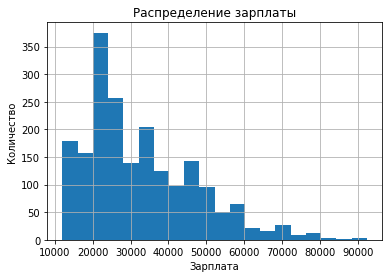

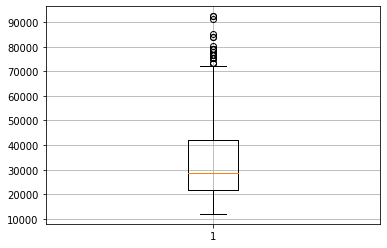

In [97]:
plt.hist(job_ready_to_quit['salary'], bins=20)
plt.grid(True)
plt.title('Распределение зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Количество')
plt.show()

plt.boxplot(job_ready_to_quit['salary'])
plt.grid(True)

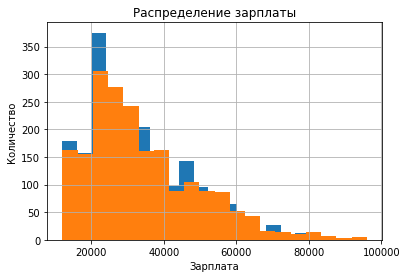

In [98]:
plt.hist(job_ready_to_quit['salary'], bins=20)
plt.grid(True)
plt.title('Распределение зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Количество')

plt.hist(test_analyze['salary'], bins=20)
plt.grid(True)
plt.title('Распределение зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Количество')

plt.show()

_Большая часть зарплат - низкие. Тем не менее мы помним, что уровень сотрудников преобладает junior. Вероятно, сотрудники приходят, получают опыт и навыки до уровня выше и уходят в другую компанию на новый уровень. Учитывая, что повышений за последний год всего 1.9 процента от общего числа неудовлетворенных сотрудников, то оно не удивительно._

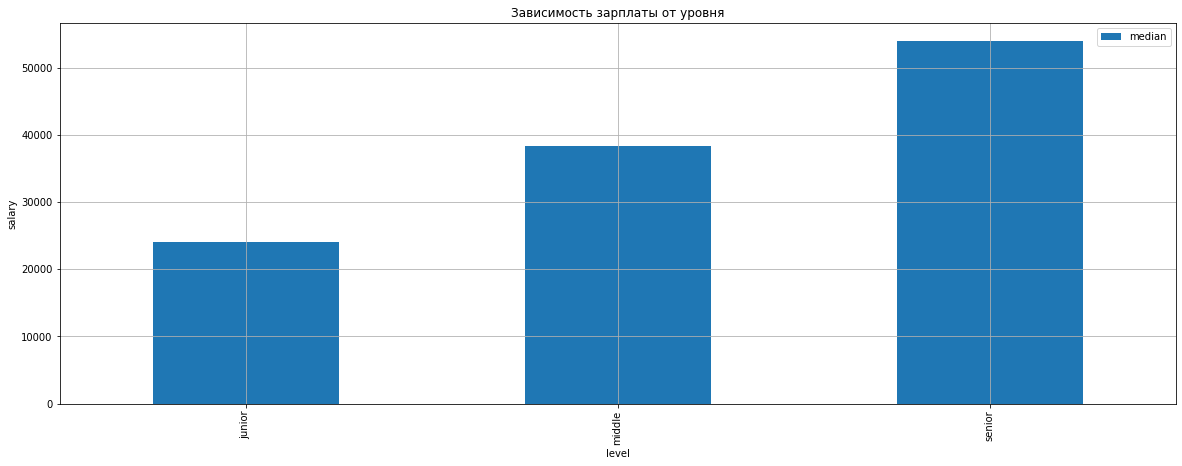

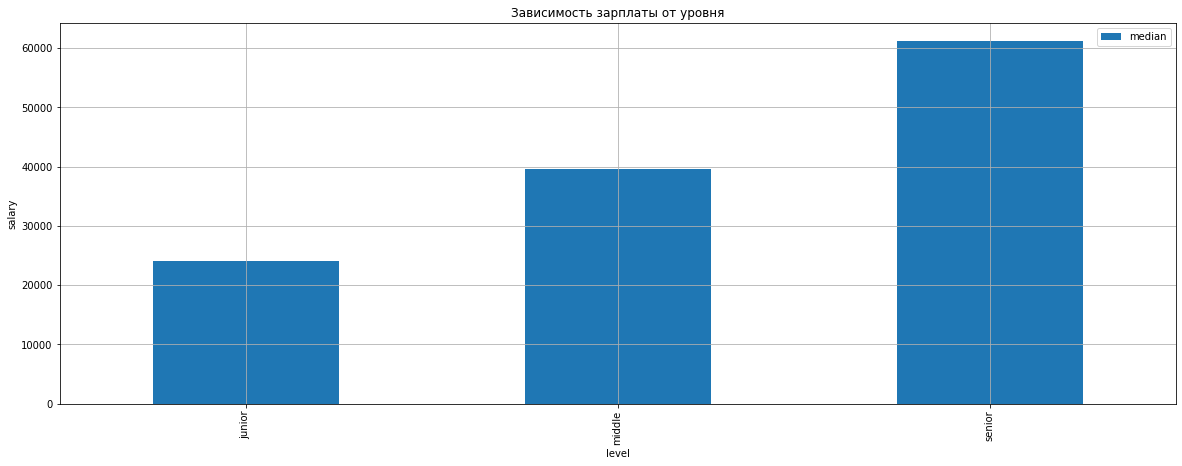

In [99]:
pivot_bar('Зависимость зарплаты от уровня', 'salary', 'level', job_ready_to_quit, 'level', 'salary', ['median'])
pivot_bar('Зависимость зарплаты от уровня', 'salary', 'level', test_analyze, 'level', 'salary', ['median'])

_Зарплаты распределены вполне ожидаемо и соответствуют уровням_

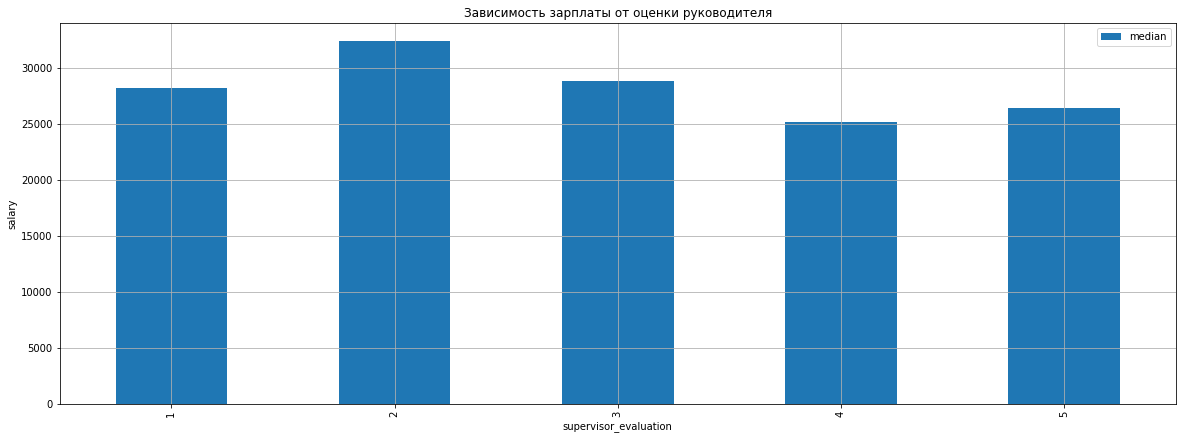

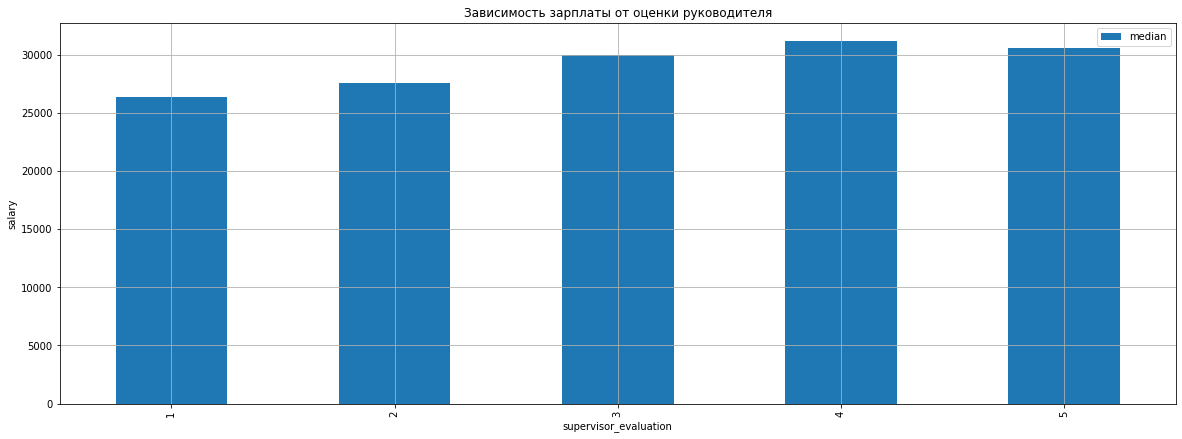

In [100]:
pivot_bar('Зависимость зарплаты от оценки руководителя', 'salary', 'supervisor_evaluation', job_ready_to_quit, 'supervisor_evaluation', 'salary', ['median'])
pivot_bar('Зависимость зарплаты от оценки руководителя', 'salary', 'supervisor_evaluation', test_analyze, 'supervisor_evaluation', 'salary', ['median'])

_Оценка руководителя никак не влияет на зарплаты. Возможно стоит пересмотреть способы оценки и систематизировать этот процесс, выдавая перспективы роста сотрудникам через оценку, а не делая ее "для галочки"(так как она не на что не влияет)._

In [101]:
job_ready_to_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1980 entries, 2 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1980 non-null   int64  
 1   dept                   1980 non-null   object 
 2   level                  1980 non-null   object 
 3   workload               1980 non-null   object 
 4   employment_years       1980 non-null   int64  
 5   last_year_promo        1980 non-null   object 
 6   last_year_violations   1980 non-null   object 
 7   supervisor_evaluation  1980 non-null   int64  
 8   salary                 1980 non-null   int64  
 9   job_satisfaction_rate  1980 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 234.7+ KB


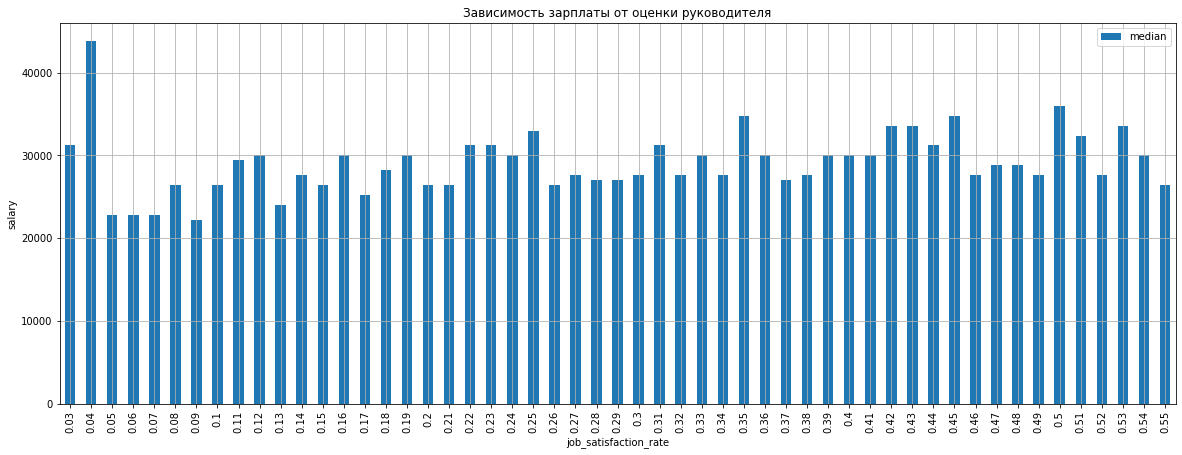

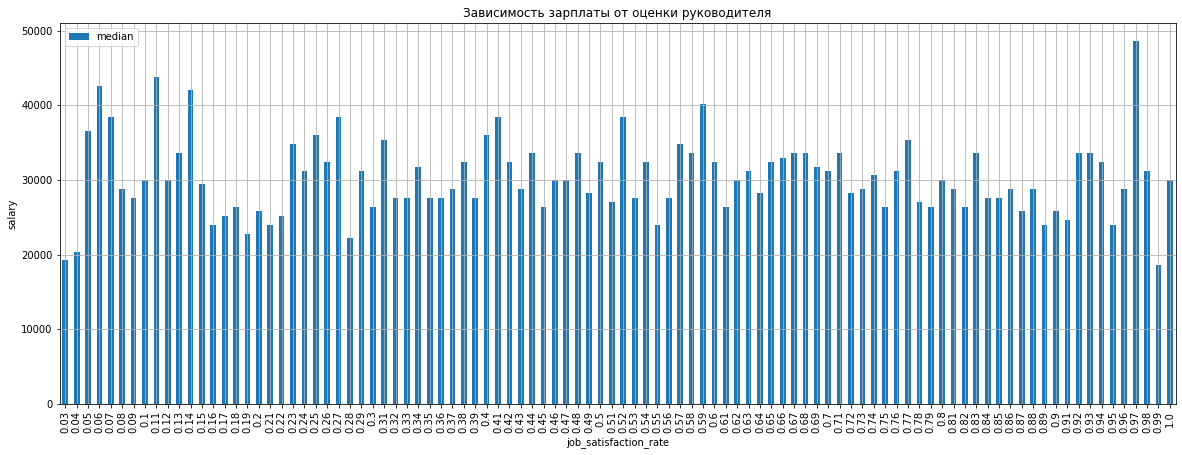

In [102]:
pivot_bar('Зависимость зарплаты от оценки руководителя', 'salary', 'job_satisfaction_rate', job_ready_to_quit, 'job_satisfaction_rate', 'salary', ['median'])
pivot_bar('Зависимость зарплаты от оценки руководителя', 'salary', 'job_satisfaction_rate', test_analyze, 'job_satisfaction_rate', 'salary', ['median'])

_Зависимости между оплатой труда и удовлетворенностью - нет. Значит текучка не из-за зарплаты._

**Вывод:**

    - Принимаем во внимание, если уровень удовлетворения сотрудника ниже медианного, то это считается сотрудник готовившийся уйти.
    - Исследовательский анализ показал, что в обеих таблицах чаще всего уходят сотрудники уровня junior.
    - Уровень зарплат не влияет на увольнение сотрудников.
    - Явная зависимость увольнения от профессионального роста сотрудников.

## Подготовка данных

In [103]:
job_satisfaction_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [104]:
job_satisfaction_train.nunique()

id                       4000
dept                        5
level                       3
workload                    3
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     68
job_satisfaction_rate      98
dtype: int64

In [105]:
job_satisfaction_train = job_satisfaction_train.set_index('id')

In [106]:
features_test.drop_duplicates(inplace=True, ignore_index=False)

In [107]:
features_test.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [108]:
job_satisfaction_target = job_satisfaction_target.set_index('id')

In [109]:
job_satisfaction_target.drop_duplicates(inplace=True, ignore_index=False)

In [110]:
features_full_test = features_test.set_index('id').merge(job_satisfaction_target, right_index=True, left_index=True)

In [111]:
features_full_test.duplicated().sum()

0

In [112]:
features_full_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 767867 to 644517
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   98 non-null     object 
 1   level                  98 non-null     object 
 2   workload               98 non-null     object 
 3   employment_years       98 non-null     int64  
 4   last_year_promo        98 non-null     object 
 5   last_year_violations   98 non-null     object 
 6   supervisor_evaluation  98 non-null     int64  
 7   salary                 98 non-null     int64  
 8   job_satisfaction_rate  98 non-null     float64
dtypes: float64(1), int64(3), object(5)
memory usage: 7.7+ KB


In [113]:
features_X_test = features_full_test.drop('job_satisfaction_rate', axis=1)

In [114]:
features_X_test.loc[features_X_test.duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
374317,sales,junior,medium,1,no,no,3,21600
130604,technology,junior,medium,1,no,no,4,34800


In [115]:
features_X_test.drop_duplicates(inplace=True, ignore_index=False)

In [116]:
features_y_test = features_full_test['job_satisfaction_rate'].astype(float)

In [117]:
features_y_test.duplicated().sum()

0

In [118]:
features_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 767867 to 644517
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   96 non-null     object
 1   level                  96 non-null     object
 2   workload               96 non-null     object
 3   employment_years       96 non-null     int64 
 4   last_year_promo        96 non-null     object
 5   last_year_violations   96 non-null     object
 6   supervisor_evaluation  96 non-null     int64 
 7   salary                 96 non-null     int64 
dtypes: int64(3), object(5)
memory usage: 6.8+ KB


In [119]:
features_y_test.info()

<class 'pandas.core.series.Series'>
Index: 98 entries, 767867 to 644517
Series name: job_satisfaction_rate
Non-Null Count  Dtype  
--------------  -----  
98 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


In [120]:
for column in ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']:
    print(column+':', features_X_test[column].unique())

dept: ['marketing' 'hr' 'purchasing' 'sales' 'technology']
level: ['middle' 'junior' 'senior']
workload: ['high' 'medium' 'low']
employment_years: [ 3  1  7  2  5  4  6  8 10  9]
last_year_promo: ['no' 'yes']
last_year_violations: ['yes' 'no']
supervisor_evaluation: [4 3 2 5 1]


In [121]:
features_y_test = features_y_test[features_y_test.index.isin(features_X_test.index)]

In [122]:
X_train = job_satisfaction_train.drop(columns='job_satisfaction_rate', axis=1)
y_train = job_satisfaction_train['job_satisfaction_rate']
X_test = features_X_test
y_test = features_y_test

ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']

ord_columns = ['level', 'workload']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

ohe_pipe = Pipeline([
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

ord_pipe = Pipeline([
    ('ord',  OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],
            ['medium', 'high', 'low'],
        ], 
        handle_unknown='use_encoded_value', unknown_value=np.nan
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

## Обучение моделей

In [123]:
def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    
    # Маска для избежания деления на ноль
    mask = denominator > 0
    smape_val = 200 * np.mean(
        np.divide(np.abs(y_true - y_pred)[mask], denominator[mask])
    )
    return smape_val

In [124]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(3, 10),
        'models__weights': ['uniform', 'distance'],
        'models__algorithm': ['auto', 'brute'], 
        'models__p': [1, 2],
        'models__metric': ['euclidean', 'manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели LGBMRegressor
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
        'models__max_depth': range(1, 50),
        'models__n_estimators': range(10, 150),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_train,
    y_train,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y_train
)

smape_scorer = make_scorer(
    smape,
    greater_is_better=False
)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=10,
    scoring=smape_scorer,
    n_iter=30,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train_1, y_train_1)
    
best_model = randomized_search.best_estimator_['models']
predictions_test = randomized_search.best_estimator_.predict(X_test_1)
train_score = (-1) * randomized_search.best_score_
test_score = smape(y_test_1, predictions_test)
    
print(best_model)
print('SMAPE лучшей модели на кросс-валидации по обучающей выборке:', train_score)
print('SMAPE на тестовой выборке:', test_score)

LGBMRegressor(max_depth=48, n_estimators=143, random_state=42, verbose=-1)
SMAPE лучшей модели на кросс-валидации по обучающей выборке: 11.625049787592943
SMAPE на тестовой выборке: 11.614791502842523


In [125]:
#results = pd.DataFrame(randomized_search.cv_results_)
#results['mean_test_score'] = results['mean_test_score'] * (-1)

# Отбор нужных колонок
#cols = [
#    'param_models',
#    'param_models__n_neighbors', 
#    'param_models__max_depth',
#    'rank_test_score',
#    'std_test_score',
#    'mean_test_score'
#]

#results[cols].sort_values('rank_test_score')

In [206]:
cv_results = pd.DataFrame(randomized_search.cv_results_)
cv_results['mean_test_score'] = cv_results['mean_test_score'] * (-1)

# Добавляем колонку с   моделями 
cv_results['модель'] = cv_results['param_models'].apply(lambda x: x.__class__.__name__)

detailed_names = {

    'mean_score_time': 'время_предсказания',
    'mean_test_score': 'метрика_на_кроссвалидации',
    'rank_test_score': 'место_по_метрике'
}

cv_results_renamed = cv_results.rename(columns=detailed_names)
best_models = (
    cv_results_renamed
    .sort_values('место_по_метрике')
    .groupby('модель')
    .first()
    .reset_index()
)

# Выводим интересующие нас cтолбцы
best_models[['модель', 'время_предсказания', 'метрика_на_кроссвалидации', 'место_по_метрике']].sort_values(by='место_по_метрике')

,модель,время_предсказания,метрика_на_кроссвалидации,место_по_метрике
1,LGBMRegressor,0.034908,11.625050,1
0,KNeighborsRegressor,0.010984,16.033674,22


In [127]:
y_test_pred = randomized_search.best_estimator_.predict(X_test)
print('SMAPE на тестовой выборке:', smape(y_test, y_test_pred))

SMAPE на тестовой выборке: 13.766135825722117


**Пробуем точечно улучшить модель LGBMRegression:**

In [128]:
#param_grid_regression = [
#    {
#        'models': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)],
#        'models__max_depth': range(1, 50),
#        'models__n_estimators': range(50, 150),
#        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
#    },

#]

#rs = RandomizedSearchCV(
#    pipe_final,
#    param_grid_regression,
#    n_jobs=-1,
#    n_iter=60,
#    cv=5,
#    scoring=smape_scorer,
#    random_state=RANDOM_STATE
#)
#rs.fit(X_train_1, y_train_1)

#print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
#print('SMAPE лучшей модели на кросс-валидации по обучающей выборке:', (-1) * rs.best_score_)

#y_test_pred = rs.best_estimator_.predict(X_test_1)
#print('SMAPE на тестовой выборке:', smape(y_test_1, y_test_pred))

In [129]:
#y_test_pred = rs.best_estimator_.predict(X_test)
#print('SMAPE на тестовой выборке:', smape(y_test, y_test_pred))

**Вывод:**

    - Была опробована 1 ранее неизвестная модель - LGBMRegressor.
    - Они показали себя лучше, чем KNeighborsClassifier и DecisionTreeClassifier.
    - Лучшей из всех моделей, для текущей задачи, является LGBMRegressor(max_depth=22, n_estimators=148, random_state=42, verbose=-1).
    - LGBMRegressor использует градиентный бустинг оптимизированный на деревьях решений, что хорошо подходит для максимальной точности на структурированных данных, как в нашей задаче.
    - Дерево в LGBM растет вертикально: выбирает лист с максимальным снижением потерь для разделения.

## Предобработка данных 2 задачи

In [130]:
quit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [131]:
quit_train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [132]:
quit_train.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [133]:
quit_train.duplicated().sum()

0

In [134]:
quit_train.nunique()

id                       4000
dept                        5
level                       3
workload                    3
employment_years           10
last_year_promo             2
last_year_violations        2
supervisor_evaluation       5
salary                     69
quit                        2
dtype: int64

In [135]:
for column in ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'quit']:
    print(column+':', quit_train[column].unique())

dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'sinior']
workload: ['high' 'medium' 'low']
employment_years: [ 2  5  1  8  4  7  3  9  6 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [4 1 3 5 2]
quit: ['no' 'yes']


In [136]:
quit_train['level'] = quit_train['level'].replace(['sinior'], 'senior')

In [137]:
quit_train['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [138]:
quit_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [139]:
quit_target.head(5)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [140]:
quit_target.isna().sum()

id      0
quit    0
dtype: int64

In [141]:
quit_target.duplicated().sum()

0

**Вывод:**

    - Заполнены наиболелее релевантными значениями NaN значения и пустые строки из таблиц с тренировочными и тестовыми входными признаками.
    - Переименованы значения с 'sinior' на 'senior'.
    - Дубликатов не найдено.

## Исследовательский анализ 2 задачи

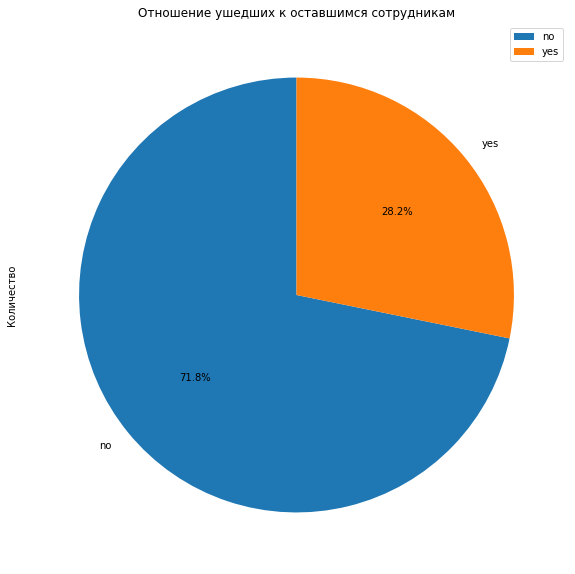

In [142]:
pivot_pie('Отношение ушедших к оставшимся сотрудникам', quit_train, 'quit', 'id', ['count'])

_Текучка составляет 28.2% - не так критично, тем не менее она есть. Мы хотим уменьшить количество уволившихся сотрудников, следовательно далее рассматриваем статистику по уволившимся сотрудникам._

In [143]:
quit_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [144]:
quit_info = quit_train.loc[quit_train['quit'] == 'yes']

In [146]:
dept_info = pd.DataFrame(quit_info['dept'].value_counts())

In [147]:
supervisor_evaluation_info = pd.DataFrame(quit_info['supervisor_evaluation'].value_counts())

In [148]:
dept_info['log_count'] = np.log(dept_info['count'] + 1)  # +1 чтобы избежать log(0)

print(dept_info[['count', 'log_count']])

            count  log_count
dept                        
sales         407   6.011267
technology    276   5.624018
purchasing    166   5.117994
marketing     163   5.099866
hr            116   4.762174


In [149]:
dept_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, sales to hr
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   count      5 non-null      int64  
 1   log_count  5 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 120.0+ bytes


In [150]:
supervisor_evaluation_info

,count
supervisor_evaluation,
3,523
4,286
2,164
1,95
5,60


In [151]:
supervisor_evaluation_info['log_count'] = np.log(supervisor_evaluation_info['count'] + 1)  # +1 чтобы избежать log(0)

supervisor_evaluation_info[['count', 'log_count']].sort_values(by='log_count', ascending=False)

,count,log_count
supervisor_evaluation,,
3,523,6.261492
4,286,5.659482
2,164,5.105945
1,95,4.564348
5,60,4.110874


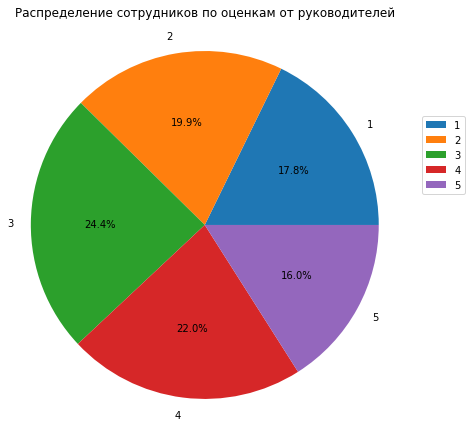

In [152]:
plt.pie(
    supervisor_evaluation_info.sort_values(by='supervisor_evaluation')['log_count'],
    labels=[1, 2, 3, 4, 5],
    autopct='%1.1f%%',
    radius=2
)

plt.title('Распределение сотрудников по оценкам от руководителей', pad=100)
plt.grid()
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper left', borderaxespad=0.)
plt.show()

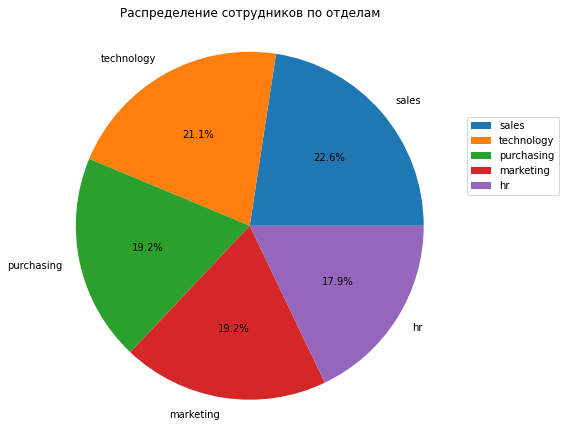

In [153]:
plt.pie(
    dept_info['log_count'],
    labels=['sales', 'technology', 'purchasing', 'marketing', 'hr'],
    autopct='%1.1f%%',
    radius=2
)

plt.title('Распределение сотрудников по отделам', pad=100)
plt.grid()
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [154]:
employment_years_info = pd.DataFrame(quit_info['employment_years'].value_counts())

In [155]:
employment_years_info['log_count'] = np.log(employment_years_info['count'] + 1)  # +1 чтобы избежать log(0)

employment_years_info[['count', 'log_count']].sort_values(by='log_count', ascending=False)

,count,log_count
employment_years,,
1,599,6.396930
2,290,5.673323
3,163,5.099866
4,27,3.332205
5,23,3.178054
6,10,2.397895
7,7,2.079442
10,3,1.386294
8,3,1.386294


In [156]:
employment_years_info.columns

Index(['count', 'log_count'], dtype='object')

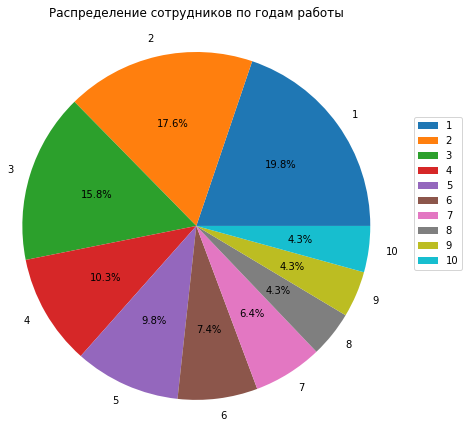

In [157]:
plt.pie(
    employment_years_info['log_count'],
    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    autopct='%1.1f%%',
    radius=2
)

plt.title('Распределение сотрудников по годам работы', pad=100)
plt.grid()
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [158]:
level_info = pd.DataFrame(quit_info['level'].value_counts())

In [159]:
level_info['log_count'] = np.log(level_info['count'] + 1)  # +1 чтобы избежать log(0)

level_info[['count', 'log_count']].sort_values(by='log_count', ascending=False)

,count,log_count
level,,
junior,1003,6.911747
middle,108,4.691348
senior,17,2.890372


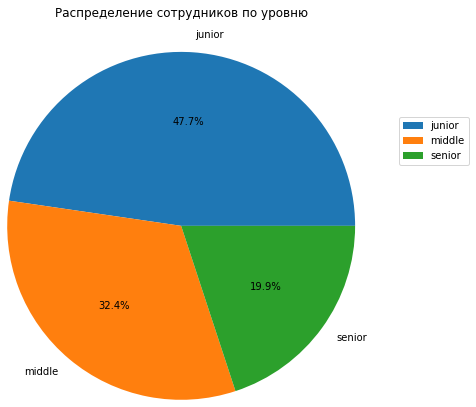

In [160]:
plt.pie(
    level_info['log_count'],
    labels=['junior', 'middle', 'senior'],
    autopct='%1.1f%%',
    radius=2
)

plt.title('Распределение сотрудников по уровню', pad=100)
plt.grid()
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [161]:
workload_info = pd.DataFrame(quit_info['workload'].value_counts())

In [162]:
workload_info['log_count'] = np.log(workload_info['count'] + 1)  # +1 чтобы избежать log(0)

workload_info[['count', 'log_count']].sort_values(by='log_count', ascending=False)

,count,log_count
workload,,
low,519,6.253829
medium,488,6.192362
high,121,4.804021


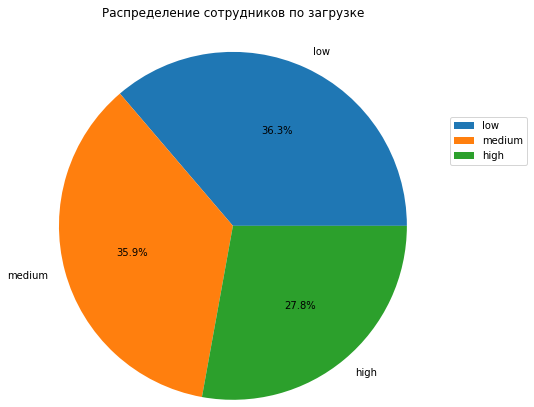

In [207]:
plt.pie(
    workload_info['log_count'],
    labels=['low', 'medium', 'high'],
    autopct='%1.1f%%',
    radius=2
)

plt.title('Распределение сотрудников по загрузке', pad=100)
plt.grid()
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper left', borderaxespad=0.)
plt.show()

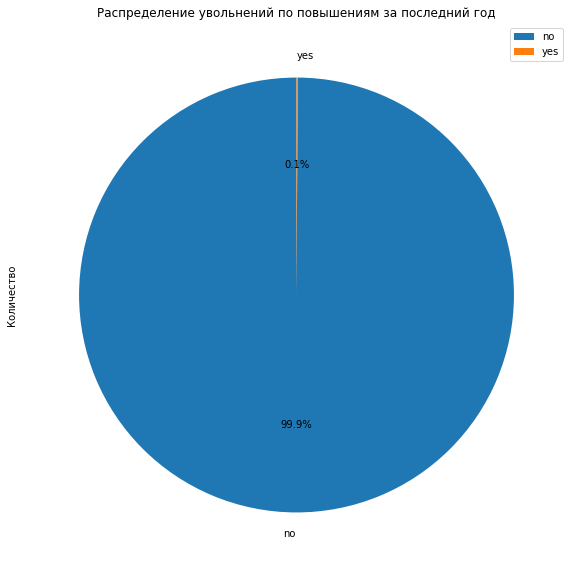

In [164]:
pivot_pie('Распределение увольнений по повышениям за последний год', quit_info, 'last_year_promo', 'id', ['count'])

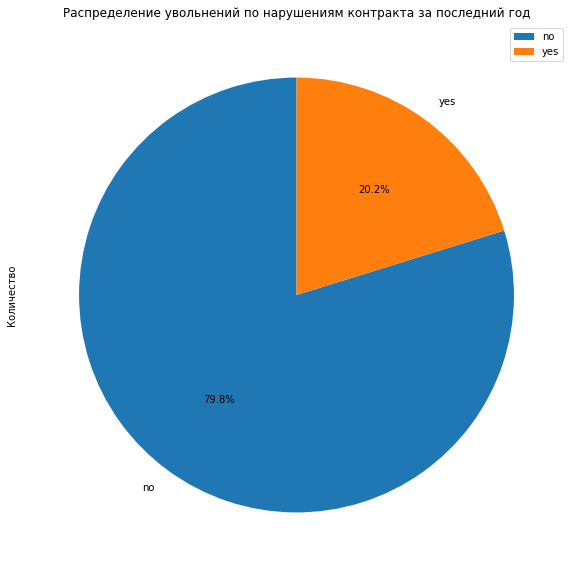

In [165]:
pivot_pie('Распределение увольнений по нарушениям контракта за последний год', quit_info, 'last_year_violations', 'id', ['count'])

_По круговым диаграммам четко прослеживается связь, что junior специалисты, не имея повышения(профессионального роста) за год уходят(и чаще всего из отдела продаж). Компании следует обратить на это внимание и удерживать junior специалистов, ведь это большое преимущество перед конкурентами, если в своей области вырастить специалиста и удержать его у себя(он принесет сильно больше дохода, чем вновь нанятый специалист, которому надо еще набрать навыка в отрасли)._

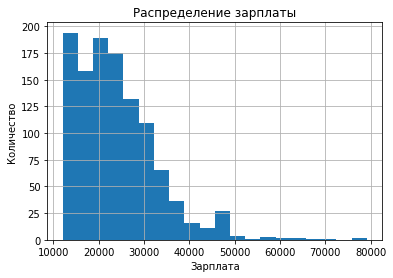

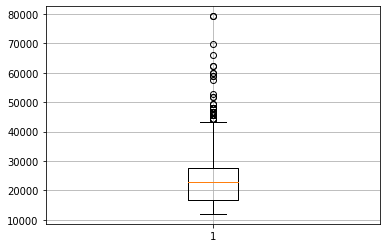

In [166]:
plt.hist(quit_info['salary'], bins=20)
plt.grid(True)
plt.title('Распределение зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Количество')
plt.show()

plt.boxplot(quit_info['salary'])
plt.grid(True)

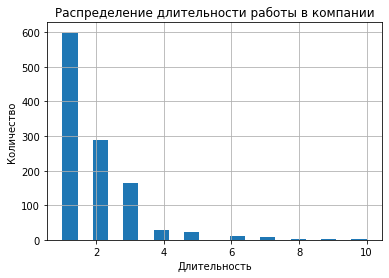

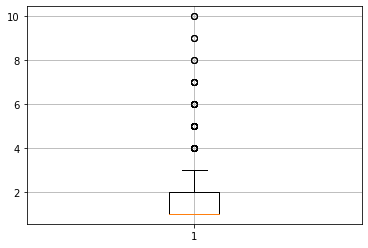

In [167]:
plt.hist(quit_info['employment_years'], bins=20)
plt.grid(True)
plt.title('Распределение длительности работы в компании')
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.show()

plt.boxplot(quit_info['employment_years'])
plt.grid(True)

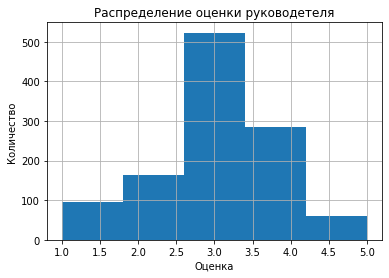

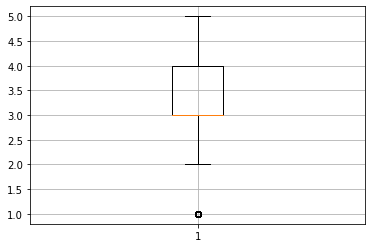

In [168]:
plt.hist(quit_info['supervisor_evaluation'], bins=5)
plt.grid(True)
plt.title('Распределение оценки руководетеля')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

plt.boxplot(quit_info['supervisor_evaluation'])
plt.grid(True)

_По оценкам видно, что чаще всего уходят средние сотрудники. Так как мы уже знаем, что это junior специалисты, которых не повышают в течение года, то стоит рассмотреть найм middle+ сотрудников, чтобы закрыть необходимые потребности компании и избежать дальнейшей текучке. Если на рынке не хватает middle+ специалистов, то имеет смысл усовершенствовать программу обучения и роста junior специалистов._

_Выбросы в этих данных вполне естественны и не подлежат устранению._

**Объединим таблицы, чтобы провести сравнение между уровнем удовлетворенности и уходом сотрудника:**

In [169]:
target_dependence = job_satisfaction_target.merge(quit_target, on='id', how='left')

In [170]:
target_dependence = target_dependence.set_index('id')

In [171]:
quit_no = target_dependence.query('quit == "no"')['job_satisfaction_rate'].astype(float)

In [172]:
quit_yes = target_dependence.query('quit == "yes"')['job_satisfaction_rate'].astype(float)

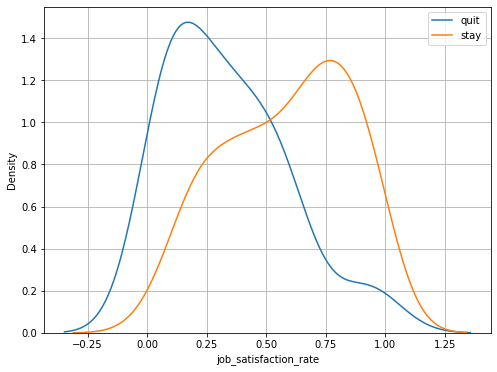

In [173]:
fig, axes = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    data=quit_yes,
    label='quit',
    ax=axes
)

sns.kdeplot(
    data=quit_no,
    label='stay',
    ax=axes
)

plt.legend()
plt.grid(True)
plt.show()

**Вывод:**

     - Текучка составляет 28.2% - не так критично, тем не менее она есть. Мы хотим уменьшить количество уволившихся сотрудников, следовательно далее рассматриваем статистику по уволившимся сотрудникам.
    - По круговым диаграммам четко прослеживается связь, что junior специалисты, не имея повышения(профессионального роста) за год уходят(и чаще всего из отдела продаж и технологического). Компании следует обратить на это внимание и удерживать junior специалистов, ведь это большое преимущество перед конкурентами, если в своей области вырастить специалиста и удержать его у себя(он принесет сильно больше дохода, чем вновь нанятый специалист, которому надо еще набрать навыка в отрасли).
    - По оценкам видно, что чаще всего уходят средние сотрудники. Так как мы уже знаем, что это junior специалисты, которых не повышают в течение года, то стоит рассмотреть найм middle+ сотрудников, чтобы закрыть необходимые потребности компании и избежать дальнейшей текучке. Если на рынке не хватает middle+ специалистов, то имеет смысл усовершенствовать программу обучения и роста junior специалистов.
    - Как можем увидеть - действительно, удовлетворенность сотрудника имеет явное влияение на его дальнейший уход.
    
**Итого мы имеем портер сотрудника, который собирается уйти:**

    - Уровень junior
    - Отдел sales или technology(примерно равный процент).
    - Сотрудник без повышения за последний год, то есть отсутствует профессиональный рост.
    - В среднем 1-2 года на рабочем месте.
    - Оценка от руководителей этих сотрудников чаще являлась средней(3).
    - У сотрудника наблюдается спад удовлетворенности в работе.
    - Загруженность слабая.

## Добавление нового входного признака

In [174]:
quit_train = quit_train.set_index('id')

In [175]:
quit_train.duplicated().sum()

1413

In [176]:
quit_train.drop_duplicates(inplace=True, ignore_index=False)

In [177]:
job_satisfaction_rate_train = randomized_search.best_estimator_.predict(quit_train)

In [178]:
quit_train['job_satisfaction_rate'] = job_satisfaction_rate_train

In [179]:
job_satisfaction_rate_test = randomized_search.best_estimator_.predict(features_test)

In [180]:
features_test['job_satisfaction_rate'] = job_satisfaction_rate_test

In [181]:
features_test.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.845007
1,686555,hr,junior,medium,1,no,no,4,30000,0.659935
2,467458,sales,middle,low,5,no,no,4,19200,0.674109
3,418655,sales,middle,low,6,no,no,4,19200,0.656978
4,789145,hr,middle,medium,5,no,no,5,40800,0.811868


In [182]:
features_test.duplicated().sum()

0

**Вывод:**

    - Были добавлены предсказанные признаки к обучающей и тестовой выборке.

## Подготовка данных задачи 2

In [183]:
quit_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2587 entries, 723290 to 692133
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   quit                   2587 non-null   object 
 9   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 222.3+ KB


In [184]:
quit_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [185]:
quit_target.set_index('id')

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes
...,...
836109,yes
180999,yes
746018,no


In [186]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   2000 non-null   object 
 2   level                  2000 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


In [187]:
features_test = features_test.merge(quit_target, on='id', how='left')

In [188]:
quit_X_train = quit_train.drop(columns='quit', axis=1)
quit_y_train = quit_train['quit']
quit_X_test = features_test.drop(columns='quit', axis=1)
quit_y_test = features_test['quit']

num_columns.append('job_satisfaction_rate')

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(quit_y_train)
y_test = label_encoder.transform(quit_y_test)

pipe_final_quit = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [189]:
original_classes = label_encoder.classes_

# Создание словаря соответствия
mapping = {index: label for index, label in enumerate(original_classes)}

print("Соответствие кодов и меток:")
print(mapping)

Соответствие кодов и меток:
{0: 'no', 1: 'yes'}


In [190]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   2000 non-null   object 
 2   level                  2000 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB


In [191]:
quit_y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2000 entries, 0 to 1999
Series name: quit
Non-Null Count  Dtype 
--------------  ----- 
2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


In [192]:
quit_X_test.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.845007
1,686555,hr,junior,medium,1,no,no,4,30000,0.659935
2,467458,sales,middle,low,5,no,no,4,19200,0.674109
3,418655,sales,middle,low,6,no,no,4,19200,0.656978
4,789145,hr,middle,medium,5,no,no,5,40800,0.811868


In [193]:
quit_y_test

0        no
1        no
2        no
3        no
4        no
       ... 
1995    yes
1996    yes
1997    yes
1998     no
1999     no
Name: quit, Length: 2000, dtype: object

In [194]:
quit_y_test

0        no
1        no
2        no
3        no
4        no
       ... 
1995    yes
1996    yes
1997    yes
1998     no
1999     no
Name: quit, Length: 2000, dtype: object

In [195]:
quit_X_train.duplicated().sum()

132

In [196]:
quit_X_train.loc[quit_X_train.duplicated()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
781190,marketing,junior,medium,1,no,no,4,24000,0.469235
282979,sales,middle,low,5,no,no,4,24000,0.824844
847141,sales,middle,low,5,no,no,4,19200,0.674109
500368,purchasing,junior,low,3,no,no,3,18000,0.505592
710365,marketing,junior,medium,3,no,no,3,30000,0.488521
...,...,...,...,...,...,...,...,...,...
779736,sales,junior,low,1,no,no,5,18000,0.658865
850499,sales,junior,low,1,no,yes,2,14400,0.093956
390944,marketing,junior,low,4,no,no,4,13200,0.644851


In [197]:
quit_X_train_clean = quit_X_train.drop_duplicates()

In [198]:
quit_y_train = quit_train['quit']

In [199]:
quit_y_train_clean = quit_y_train.loc[quit_X_train_clean.index]

## Обучение модели

In [200]:
param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 10),
        'models__weights': ['uniform', 'distance'],
        'models__algorithm': ['auto', 'brute'], 
        'models__p': [1, 2],
        'models__metric': ['euclidean', 'manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели LGBMClassifier
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1, class_weight='balanced')],
        'models__max_depth': range(1, 21),
        'models__n_estimators': range(80, 120),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    # словарь для модели RandomForestClassifier
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 21),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'models__n_estimators': range(10, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]

# закодировали очищенные данные
quit_y_train = label_encoder.transform(quit_y_train_clean)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    quit_X_train_clean,
    quit_y_train_clean,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = quit_y_train_clean
)

randomized_search_quit = RandomizedSearchCV(
    pipe_final_quit, 
    param_grid_quit, 
    cv=10,
    scoring='roc_auc',
    n_iter=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_quit.fit(X_train_2, y_train_2)
    
best_model_quit = randomized_search_quit.best_estimator_['models']
quit_predictions = randomized_search_quit.best_estimator_.predict_proba(X_test_2)[:, 1]
current_train_score = randomized_search_quit.best_score_
current_test_score = roc_auc_score(y_test_2, quit_predictions)
    
print(best_model_quit)
print('ROC-AUC лучшей модели на кросс-валидации по обучающей выборке:', current_train_score)
print('ROC-AUC на тестовой выборке:', current_test_score)

LGBMClassifier(class_weight='balanced', max_depth=1, n_estimators=113,
               random_state=42, verbose=-1)
ROC-AUC лучшей модели на кросс-валидации по обучающей выборке: 0.9365176289969914
ROC-AUC на тестовой выборке: 0.9391386437429377


In [201]:
y_test_pred = randomized_search_quit.best_estimator_.predict_proba(quit_X_test)[:,1]
print('ROC_AUC на тестовой выборке:', roc_auc_score(quit_y_test, y_test_pred))

ROC_AUC на тестовой выборке: 0.9238125753175684


In [205]:
cv_results_quit = pd.DataFrame(randomized_search_quit.cv_results_)

# Добавляем колонку с   моделями 
cv_results_quit['модель'] = cv_results_quit['param_models'].apply(lambda x: x.__class__.__name__)

detailed_names = {

    'mean_score_time': 'время_предсказания',
    'mean_test_score': 'метрика_на_кроссвалидации',
    'rank_test_score': 'место_по_метрике'
}

cv_results_renamed_quit = cv_results_quit.rename(columns=detailed_names)
best_models_quit = (
    cv_results_renamed_quit
    .sort_values('место_по_метрике')
    .groupby('модель')
    .first()
    .reset_index()
)

# Выводим интересующие нас cтолбцы
best_models_quit[['модель', 'время_предсказания', 'метрика_на_кроссвалидации', 'место_по_метрике']].sort_values(by='место_по_метрике')

,модель,время_предсказания,метрика_на_кроссвалидации,место_по_метрике
2,LGBMClassifier,0.043861,0.936518,1
3,RandomForestClassifier,0.008834,0.935263,2
1,KNeighborsClassifier,0.009896,0.910964,46
0,DecisionTreeClassifier,0.006196,0.854403,50


## Общий вывод

**Описание задачи:**

    HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
    
    Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.
    
    Перед нами стояло две задачи - определения уровня удовлетворенности сотрудника в компании и классификация признака уволится он или нет.
    
**Исходные данные и предобработка:**

    - Были выгружены данные из пяти разных файлов в четыре переменные. Все данные соответствуют описанию.
    - В таблице job_satisfaction_train 4000 записи с колонками, совпадающими с описанием.
    - В таблице quit_train 4000 записи с колонками, совпадающими с описанием.
    - В таблице features_test 2000 записей с колонками, совпадающими с описанием.
    - В таблице job_satisfaction_target 2000 записей с колонками id и job_satisfaction_rate.
    - В таблице quit_target 2000 записей с колонками id и quit.
    - Заполнены наиболелее релевантными значениями NaN значения и пустые строки из таблиц с тренировочными и тестовыми входными признаками.
    - Переименованы значения с 'sinior' на 'senior'.
    - В таблице job_satisfaction_train целевой признак приведет к типу float.
    - Дубликатов не найдено. Но позже, в ходе объединения таблиц были убраны некоторые дубликаты.

**Исследовательский анализ:**

    - Принимаем во внимание, если уровень удовлетворения сотрудника ниже медианного, то это считается сотрудник готовившийся уйти.
    - Исследовательский анализ показал, что в обеих таблицах чаще всего уходят сотрудники уровня junior.
    - Уровень зарплат не влияет на увольнение сотрудников.
    - Явная зависимость увольнения от профессионального роста сотрудников.
    - По оценкам видно, что чаще всего уходят средние сотрудники. Так как мы уже знаем, что это junior специалисты, которых не повышают в течение года, то стоит рассмотреть найм middle+ сотрудников, чтобы закрыть необходимые потребности компании и избежать дальнейшей текучке. Если на рынке не хватает middle+ специалистов, то имеет смысл усовершенствовать программу обучения и роста junior специалистов.
    - Действительно, удовлетворенность сотрудника имеет явное влияение на его дальнейший уход.

_Итого мы имеем портер сотрудника, который собирается уйти:_

    - Уровень junior
    - Отдел sales или technology(примерно равный процент).
    - Сотрудник без повышения за последний год, то есть отсутствует профессиональный рост.
    - В среднем 1-2 года на рабочем месте.
    - Оценка от руководителей этих сотрудников чаще являлась средней(3).
    - У сотрудника наблюдается спад удовлетворенности в работе.
    - Загруженность слабая.
    
**Обучение моделей:**

    - Была опробована 1 ранее неизвестная модель - LGBMRegressor.
    - Они показали себя лучше, чем KNeighborsClassifier и DecisionTreeClassifier.
    - Лучшей из всех моделей, для текущей задачи, является LGBMRegressor(max_depth=22, n_estimators=148, random_state=42, verbose=-1).
    - LGBMRegressor использует градиентный бустинг оптимизированный на деревьях решений, что хорошо подходит для максимальной точности на структурированных данных, как в нашей задаче.
    - Дерево в LGBM растет вертикально: выбирает лист с максимальным снижением потерь для разделения.
    
    - LGBMClassifier справилась с этой задачей классификации лучше всех, как и LGBMRegression.
    - Лучшая модель LGBMClassifier(max_depth=1, n_estimators=113, random_state=42, verbose=-1).
    - Причины победы этой модели схожи с предыдущей задачей - LGBM использует градиентный бустинг, что хорошо сочетается с нашими данными.
    
**Рекомендации:**

    - Следует обратить внимание на показатель удовлетворенности сотрудников - так как он оказывает прямое воздействие на увольнение.
    - Также следует обратить внимание на то, что в компании отсутствует рост, средних по оценке от руководителей, junior специалистов. Вероятно следует улучшить или структурировать обучение или стимуляцию роста таких сотрудников.
    - Сотрудники увольняются спустя год работы. Следует обратить внимание на удержания и стимуляцию вновь прибивших сотрудников.
    - Вероятно имеет смысл ввести годовое грейдирование, в рамках которого можно закрыть некоторые проблемы ухода сотрудников, особенно уровня junior. Тем не менее делать это следует аккуратно, так как это может негативно сказаться на специалистах высокого класса, если подойти к вопросу только со стороны стимуляции junior специалистов.